In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 4 2024

@author: Yaning
Data from Ben
Data file name: intertemporal_choice_dataset_all_trials.csv
"""

import torch
import pyro
import math
import pandas as pd
from pyro.distributions import Normal, Bernoulli, Gamma
from pyro.distributions.util import scalar_like
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.mcmc.util import initialize_model, summary
from pyro.util import ignore_experimental_warning
from pyro import poutine
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%run Documents/pyro_models/files_to_run/data_analysis_without_version.ipynb

/tmp/ipykernel_898618/26966324.py:14: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


['', 'trial', 'val_basic', 'delay', 'val_prc', 'response', 'RT', 'respSide', 'sideNOW', 'Version', 'loopID', 'Context']


In [2]:
data[1, 1]

array([[  1.    ,  20.    , 122.    , ...,   3.0311,   2.    ,   1.    ],
       [  2.    ,  20.    ,   3.    , ...,   2.0215,   2.    ,   1.    ],
       [  3.    ,  20.    ,   7.    , ...,   6.8192,   2.    ,   1.    ],
       ...,
       [168.    ,  20.    ,   7.    , ...,   1.257 ,   2.    ,   1.    ],
       [169.    ,  20.    ,   1.    , ...,   1.4933,   2.    ,   1.    ],
       [170.    ,  20.    ,  24.    , ...,   1.3219,   2.    ,   1.    ]])

In [9]:
context = 1
person = 0

actions = data[context, person, :, 4]
delays = np.array([i / 10 for i in data[context, person, :, 2]])
ss_values = data[context, person, :, 1]
ll_values = []
for i in range(len(ss_values)):
    ll_values.append(ss_values[i]*data[context, person, i, 3])
ll_values = np.array(ll_values)

In [10]:
ll_values

array([38. , 45. , 45. , 41. , 61. , 31. , 51. , 41. , 21. , 21. , 23. ,
       31. , 61. , 45. , 33. , 77. , 25. , 77. , 25. , 38. , 21.1, 23. ,
       41. , 21. , 31. , 21. , 33. , 61. , 38. , 21. , 51. , 33. , 45. ,
       31. , 33. , 29. , 69. , 37. , 51. , 29. , 23. , 61. , 61. , 31. ,
       29. , 57. , 69. , 77. , 31. , 41. , 38. , 57. , 33. , 61. , 21.1,
       33. , 57. , 29. , 29. , 38. , 27. , 38. , 61. , 77. , 69. , 57. ,
       69. , 27. , 61. , 37. , 21. , 21.1, 51. , 25. , 57. , 21. , 31. ,
       77. , 25. , 33. , 57. , 21. , 77. , 23. , 69. , 21. , 37. , 23. ,
       27. , 77. , 37. , 23. , 21. , 37. , 25. , 29. , 37. , 23. , 21.1,
       77. , 51. , 21.1, 77. , 38. , 37. , 57. , 61. , 41. , 21.1, 37. ,
       29. , 51. , 51. , 38. , 23. , 25. , 69. , 45. , 38. , 51. , 37. ,
       31. , 45. , 41. , 45. , 61. , 25. , 69. , 69. , 31. , 57. , 29. ,
       27. , 51. , 27. , 27. , 27. , 31. , 25. , 41. , 69. , 77. , 27. ,
       38. , 45. , 51. , 25. , 23. , 27. , 25. , 29

In [11]:
actions = torch.tensor(actions)
delays = torch.tensor(delays)
ss_values = torch.tensor(ss_values)
ll_values = torch.tensor(ll_values)

In [12]:
pyro.set_rng_seed(1)


In [13]:
# MCMC model
# simulate parameters:
# mean_u 0
# var_u 3
# var_es 0.5

chain_num = 3
sample_num = 300
def model(actions, delays, ss_values, ll_values):
    mean_u = pyro.sample("mean_u", Normal(loc = torch.tensor(0.), scale = torch.tensor(2.)))
    # sigma_u = pyro.sample("sigma_u", Gamma(torch.tensor(1.), torch.tensor(2.)))
    # sigma_es = pyro.sample("sigma_es", Gamma(torch.tensor(2.), torch.tensor(1.)))
    log_sigma_u = pyro.sample("log_sigma_u", Normal(torch.tensor(1.), torch.tensor(2.)))
    log_sigma_es = pyro.sample("log_sigma_es", Normal(torch.tensor(1.), torch.tensor(2.)))
    beta = pyro.sample("beta", Gamma(torch.tensor(1.), torch.tensor(2.)))
    num = actions.shape[0]
    e_vals = []
    # for i, actions, delays, ss_values, ll_values in zip(range(len(actions)), actions, delays, ss_values, ll_values):
    #     # with pyro.plate("num", num):
    #     e = (mean_u*delays*var_es + ll_values*var_u)/(delays*var_es + var_u)
    #     p = torch.nn.functional.softmax(torch.tensor([e, ss_values]), dim = 0)[0]
    #     return pyro.sample("obs", Bernoulli(probs = p), obs=actions)
    with pyro.plate("num", num):
        sigma_u = torch.exp(log_sigma_u)
        sigma_es = torch.exp(log_sigma_es)
        e_vals.append((mean_u*delays*sigma_es + ll_values*sigma_u)/(delays*sigma_es + sigma_u))
        softmax_args = torch.stack([beta*e_vals[-1], beta*ss_values])
        p = torch.softmax(softmax_args, dim = 0)[0]
        return pyro.sample("obs", Bernoulli(probs = p), obs=actions)
# pyro.render_model(model, model_args=(actions, delays, ss_values, ll_values), render_params=True, render_distributions=True)



mcmc_kernel = NUTS(model)                                               # initialize proposal distribution kernel
mcmc = MCMC(mcmc_kernel, num_samples=sample_num, num_chains = chain_num, warmup_steps=50)  # initialize MCMC class

mcmc.run(actions, delays, ss_values, ll_values)

Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/torch/__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/torch/__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


Warmup [3]:   0%|          | 0/350 [00:00, ?it/s]

[ERROR LOG CHAIN:0]Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork
Traceback (most recent call last):
  File "/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/pyro/infer/mcmc/api.py", line 125, in run
    for sample in _gen_samples(
  File "/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/pyro/infer/mcmc/api.py", line 144, in _gen_samples
    kernel.setup(warmup_steps, *args, **kwargs)
  File "/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/pyro/infer/mcmc/hmc.py", line 345, in setup
    self._initialize_model_properties(args, kwargs)
  File "/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/pyro/infer/mcmc/hmc.py", line 279, in _initialize_model_properties
    init_params, potential_fn, transforms, trace = initialize_model(
                                                   ^^^^^^^^^^^^^^^^^
  File "/home/yaning

RuntimeError: Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork

In [15]:
mcmc_kernel.cleanup()
mcmc_kernel.clear_cache()

In [27]:
mcmc_kernel.end_warmup()

In [7]:
test = mcmc.summary(prob=0.9)


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
          beta      0.42      0.08      0.41      0.29      0.53    606.77      1.00
  log_sigma_es      0.30      1.49      0.31     -2.50      2.50    207.77      1.02
   log_sigma_u      1.81      1.51      1.84     -0.50      4.54    212.80      1.02
        mean_u     -0.40      1.97     -0.35     -3.45      2.77    522.95      1.01

Number of divergences: 0


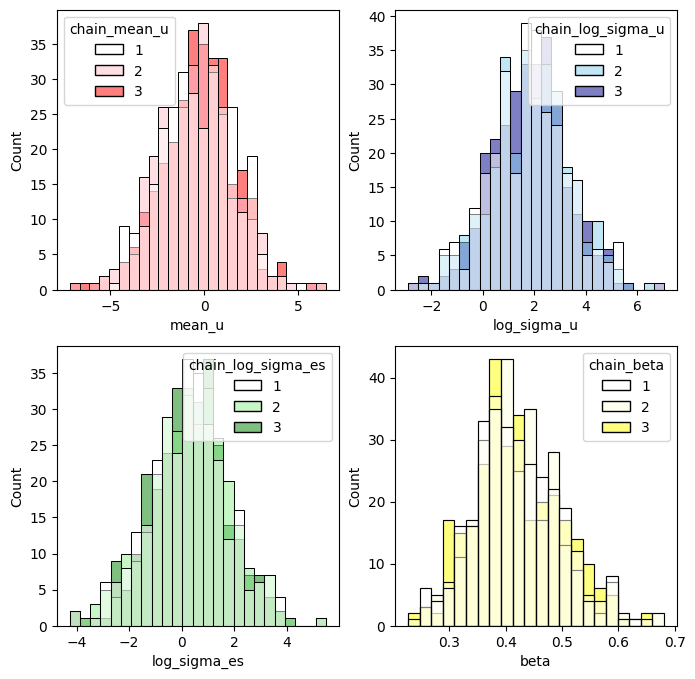

In [8]:
# get posterior with pandas dataframe
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

mean_u = pd.DataFrame(mcmc.get_samples()['mean_u'],columns=['mean_u'])
mean_u['chain_mean_u'] = torch.tensor([1,2,3]).repeat(300)
sns.histplot(data=mean_u, x='mean_u',hue='chain_mean_u', palette=['white', 'pink', 'red'], ax=axs[0,0])

log_sigma_u = pd.DataFrame(mcmc.get_samples()['log_sigma_u'],columns=['log_sigma_u'])
log_sigma_u['chain_log_sigma_u'] = torch.tensor([1,2,3]).repeat(300)
sns.histplot(data=log_sigma_u, x='log_sigma_u',hue='chain_log_sigma_u', palette=['white', 'skyblue', 'darkblue'], ax=axs[0,1])

log_sigma_es = pd.DataFrame(mcmc.get_samples()['log_sigma_es'],columns=['log_sigma_es'])
log_sigma_es['chain_log_sigma_es'] = torch.tensor([1,2,3]).repeat(300)
sns.histplot(data=log_sigma_es, x='log_sigma_es',hue='chain_log_sigma_es', palette=['white', 'lightgreen', 'green'], ax=axs[1,0])

beta = pd.DataFrame(mcmc.get_samples()['beta'],columns=['beta'])
beta['chain_beta'] = torch.tensor([1,2,3]).repeat(300)
sns.histplot(data=beta, x='beta',hue='chain_beta', palette=['white', 'lightyellow', 'yellow'], ax=axs[1,1])

plt.show()

In [10]:
results = pd.concat([mean_u, log_sigma_u, log_sigma_es, beta], axis=1, join='inner')

In [11]:
results.to_csv('Documents/pyro_models/results/MCMC_mit_log_gamble_0.csv', index=False)